In [1]:
import os, requests, torch, transformers, warnings
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.utils import make_grid
from io import BytesIO

ckpt_name = 'aehrc/cxrmate-single-tf'

encoder_decoder = transformers.AutoModel.from_pretrained(ckpt_name, trust_remote_code=True)
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained(ckpt_name)
image_processor = transformers.AutoFeatureExtractor.from_pretrained(ckpt_name)

test_transforms = transforms.Compose(
    [
        transforms.Resize(size=image_processor.size['shortest_edge']),
        transforms.CenterCrop(size=[
            image_processor.size['shortest_edge'],
            image_processor.size['shortest_edge'],
        ]
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std,
        ),
    ]
)

A new version of the following files was downloaded from https://huggingface.co/aehrc/cxrmate-single-tf:
- modelling_single.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/datasets/work/hb-mlaifsp-mm/work/environments/cxrmate/lib/python3.9/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [3]:
url = 'https://www.stritch.luc.edu/lumen/meded/radio/curriculum/IPM/PCM/86a_labelled.jpg'
response = requests.get(url)
image_a = Image.open(BytesIO(response.content))
image_a = image_a.convert('RGB')

url = 'https://prod-images-static.radiopaedia.org/images/566180/d527ff6fc1482161c9225345c4ab42_big_gallery.jpg'
response = requests.get(url)
image_b = Image.open(BytesIO(response.content))
image_b = image_b.convert('RGB')

image_a = test_transforms(image_a)
image_b = test_transforms(image_b)

images = torch.stack([image_a, image_b], dim=0)
images.shape


torch.Size([2, 3, 384, 384])

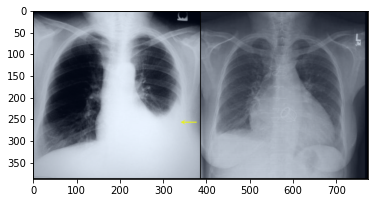

In [10]:
plt.imshow(make_grid(images, normalize=True).permute(1, 2, 0))

In [8]:
outputs = encoder_decoder.generate(
    pixel_values=images,
    special_token_ids=[tokenizer.sep_token_id],
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    max_length=256,
    num_beams=4,
)

findings, impression = encoder_decoder.split_and_decode_sections(
    outputs.sequences,
    [tokenizer.sep_token_id, tokenizer.eos_token_id],
    tokenizer,
)

In [9]:
for i, j in zip(findings, impression):
    print(f'Findings: {i}\nImpression: {j}\n')

Findings: There is a moderate to large left pleural effusion with adjacent atelectasis. The right lung is clear. No pneumothorax identified. The size and appearance of the cardiomediastinal silhouette is unchanged.
Impression: Moderate to large left pleural effusion with adjacent atelectasis.

Findings: The patient has had prior median sternotomy with aortic valve replacement. Sternotomy wires are intact and aligned. Sequential radiographs show advancement of a feeding tube initially positioned in the mid esophagus, through the gastroesophageal junction, and into the stomach. Moderate cardiomegaly despite the projection is unchanged. Mediastinal contours are stable. There is no pneumothorax. Mild pulmonary edema is unchanged.
Impression: Feeding tube terminates in stomach. Stable mild pulmonary edema. Stable moderate cardiomegaly.

